In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

## 1. Data Selection & Factor Calculation

Get the price data from CRSP monthly, financials data from compustat, beta data from WRDS and calculate the related factors in each dataset.

In [4]:
price_data = pd.read_csv('price.csv')
price_data.rename(columns={'date': 'DATE','sprtrn': 'BENCH'}, inplace=True)
price_data['DATE'] = pd.to_datetime(price_data['DATE']) + pd.offsets.MonthEnd(0)
price_data['PRC'] = price_data['PRC'].abs()
price_data = price_data.groupby('PERMNO', as_index=False).apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
price_data = price_data[(~price_data['PERMNO'].isin([75016, 75028]))&(~price_data['TICKER'].isna())]
price_data.drop(columns=['TICKER'],inplace=True)
price_data

PERMNO       DATE        PRC         VOL        RET     SHROUT  \
0   0        10057 1990-01-31   10.25000      3873.0  -0.048276     6291.0   
    1        10057 1990-02-28   10.12500      2495.0  -0.012195     6291.0   
    2        10057 1990-03-31    9.62500      3004.0  -0.049383     6291.0   
    3        10057 1990-04-30    9.12500      1178.0  -0.041558     6291.0   
    4        10057 1990-05-31    9.00000      1719.0  -0.013699     6291.0   
...            ...        ...        ...         ...        ...        ...   
738 197556   93436 2023-08-31  258.07999  25029170.0  -0.034962  3173994.0   
    197557   93436 2023-09-30  250.22000  24395440.0  -0.030456  3179000.0   
    197558   93436 2023-10-31  200.84000  25905681.0  -0.197346  3178921.0   
    197559   93436 2023-11-30  240.08000  26395792.0   0.195379  3178921.0   
    197560   93436 2023-12-31  248.48000  22852106.0   0.034988  3178921.0   

               BENCH  
0   0      -0.068817  
    1       0.008539  
    2       0.024255  
    3      -0.026887  
    4       0.091989  
...              ...  
738 197556 -0.017716  
    197557 -0.048719  
    197558 -0.021980  
    197559  0.089179  
    197560  0.044229  

[197503 rows x 7 columns]

### Liquidity

In [6]:
price_data['LIQUIDITY'] = np.log(price_data['VOL']/price_data['SHROUT'])

### Size

In [8]:
price_data['SIZE'] = price_data['PRC'] * price_data['SHROUT']
price_data['SIZE'] = np.log(price_data['SIZE'])

### Momentum

In [10]:
price_data['PCT_CHANGE'] = price_data.groupby('PERMNO')['PRC'].pct_change()
price_data['RETURN'] = price_data.groupby('PERMNO')['PCT_CHANGE'].shift(-1)
price_data['LOG_RETURN'] = np.log(price_data['RETURN'] + 1)
price_data['MOMENT0'] = (
    price_data.groupby('PERMNO')['LOG_RETURN']
    .transform(lambda x: x.rolling(12).sum())
)
price_data['MOMENTUM'] = price_data.groupby(['PERMNO'])['MOMENT0'].shift(1)

### Non-linear size  

In [12]:
price_data['SIZE_CUBE']=price_data['SIZE']**3
X = price_data['SIZE']
X = sm.add_constant(X)
y = price_data['SIZE_CUBE']
model = sm.OLS(y,X).fit()
price_data['NLSIZE'] = model.resid

In [13]:
price_data = price_data[['PERMNO','DATE','BENCH','LIQUIDITY','SIZE','MOMENTUM','NLSIZE']]
price_data

PERMNO       DATE     BENCH  LIQUIDITY       SIZE  MOMENTUM  \
0   0        10057 1990-01-31 -0.068817  -0.485091  11.074153       NaN   
    1        10057 1990-02-28  0.008539  -0.924831  11.061883       NaN   
    2        10057 1990-03-31  0.024255  -0.739175  11.011239       NaN   
    3        10057 1990-04-30 -0.026887  -1.675302  10.957893       NaN   
    4        10057 1990-05-31  0.091989  -1.297377  10.944100       NaN   
...            ...        ...       ...        ...        ...       ...   
738 197556   93436 2023-08-31 -0.017716   2.065051  20.523771 -0.065717   
    197557   93436 2023-09-30 -0.048719   2.037830  20.494418 -0.058332   
    197558   93436 2023-10-31 -0.021980   2.097920  20.274561 -0.124817   
    197559   93436 2023-11-30  0.089179   2.116663  20.453025  0.209512   
    197560   93436 2023-12-31  0.044229   1.972501  20.487415  0.701716   

                 NLSIZE  
0   0        360.739324  
    1        364.341812  
    2        379.316380  
    3        395.273198  
    4        399.429529  
...                 ...  
738 197556  1400.605595  
    197557  1382.971228  
    197558  1254.246803  
    197559  1358.283591  
    197560  1378.779704  

[197503 rows x 7 columns]

In [14]:
financials_data = pd.read_csv('financials.csv')
financials_data.rename(columns={'permno': 'PERMNO','public_date':'DATE'}, inplace=True)
financials_data['DATE'] = pd.to_datetime(financials_data['DATE']) + pd.offsets.MonthEnd(0)
financials_data = financials_data.groupby('PERMNO', as_index=False).apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
financials_data.drop(columns=['TICKER'],inplace=True)
financials_data

PERMNO       DATE     bm  pe_inc  debt_assets  PEG_1yrforward
0   0        10057 1990-01-31  0.976   9.579        0.493           0.332
    1        10057 1990-02-28  0.958   8.438        0.495           0.569
    2        10057 1990-03-31  0.958   8.021        0.495           0.541
    3        10057 1990-04-30  0.958   7.604        0.495           0.513
    4        10057 1990-05-31  1.106   8.036        0.496           0.759
...            ...        ...    ...     ...          ...             ...
644 176525   93436 2023-08-31  0.062  73.318        0.436           0.688
    176526   93436 2023-09-30  0.062  71.085        0.436           0.688
    176527   93436 2023-10-31  0.062  57.057        0.436           0.688
    176528   93436 2023-11-30  0.067  77.445        0.429           0.688
    176529   93436 2023-12-31  0.067  80.155        0.429           0.688

[176530 rows x 6 columns]

### Book to price

In [16]:
financials_data['BTOP'] = financials_data['bm']

### Earning Yield

In [18]:
financials_data['EARNING'] = 1 / (financials_data['pe_inc'] + 1e-8)

### Growth

In [20]:
financials_data['GROWTH'] = 1 / ((financials_data['PEG_1yrforward']+ 1e-8) / financials_data['pe_inc'])

### Leverage

In [22]:
financials_data['LEVERAGE'] = financials_data['debt_assets']

In [23]:
financials_data = financials_data[['PERMNO','DATE','BTOP','EARNING','GROWTH','LEVERAGE']]
financials_data

PERMNO       DATE   BTOP   EARNING      GROWTH  LEVERAGE
0   0        10057 1990-01-31  0.976  0.104395   28.852409     0.493
    1        10057 1990-02-28  0.958  0.118511   14.829525     0.495
    2        10057 1990-03-31  0.958  0.124673   14.826247     0.495
    3        10057 1990-04-30  0.958  0.131510   14.822612     0.495
    4        10057 1990-05-31  1.106  0.124440   10.587615     0.496
...            ...        ...    ...       ...         ...       ...
644 176525   93436 2023-08-31  0.062  0.013639  106.566859     0.436
    176526   93436 2023-09-30  0.062  0.014068  103.321219     0.436
    176527   93436 2023-10-31  0.062  0.017526   82.931685     0.436
    176528   93436 2023-11-30  0.067  0.012912  112.565405     0.429
    176529   93436 2023-12-31  0.067  0.012476  116.504359     0.429

[176530 rows x 6 columns]

### Beta

In [25]:
beta_data = pd.read_csv('beta.csv')
beta_data.rename(columns={'b_mkt': 'BETA','exret':'EXRET'}, inplace=True)
beta_data['DATE'] = pd.to_datetime(beta_data['DATE']) + pd.offsets.MonthEnd(0)
beta_data = beta_data.groupby('PERMNO', as_index=False).apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
beta_data = beta_data.replace(['B','C'],0)
beta_data['EXRET'] = beta_data['EXRET'].str.strip().str.rstrip('%').astype('float') / 100
beta_data['RET'] = beta_data['RET'].str.strip().str.rstrip('%').astype('float') / 100

### Volatility

In [27]:
beta_data['VOLATILITY'] = (
    beta_data.groupby('PERMNO')['EXRET']
    .rolling(window=12)
    .std()
    .reset_index(level=0, drop=True)
)
beta_data = beta_data[['PERMNO','DATE','RET','EXRET','BETA','VOLATILITY']]
beta_data

PERMNO       DATE       RET     EXRET    BETA  VOLATILITY
0   0        10057 1990-01-31 -0.048276  0.028359  1.0449         NaN
    1        10057 1990-02-28 -0.012195 -0.029493  1.0516         NaN
    2        10057 1990-08-31 -0.203125 -0.103157  1.0720         NaN
    3        10057 1991-09-30 -0.056604 -0.043264  1.1321         NaN
    4        10057 1991-08-31 -0.036364 -0.067134  1.1283         NaN
...            ...        ...       ...       ...     ...         ...
613 151896   93436 2023-07-31  0.021622 -0.035284  1.6281    0.093327
    151897   93436 2023-05-31  0.241130  0.231890  1.6062    0.115512
    151898   93436 2023-04-30 -0.207992 -0.221296  1.6113    0.128511
    151899   93436 2023-06-30  0.283627  0.175707  1.6326    0.137886
    151900   93436 2023-10-31 -0.197346 -0.150308  1.6519    0.144890

[151901 rows x 6 columns]

In [28]:
ratios = pd.read_csv('financials1.csv')
ratios['divyield'] = ratios['divyield'].str.strip().str.rstrip('%').astype('float') / 100
ratios.rename(columns={'permno':'PERMNO','public_date':'DATE'},inplace=True)
ratios['DATE'] = pd.to_datetime(ratios['DATE']) + pd.offsets.MonthEnd(0)
ratios = ratios.groupby('PERMNO', as_index=False).apply(lambda group: group.fillna(method='ffill').fillna(method='bfill').fillna(0))
ratios

PERMNO       DATE    roe   roce  accrual  divyield
0   0        10057 1990-01-31  0.082  0.078   -0.070    0.0390
    1        10057 1990-02-28  0.092  0.087   -0.049    0.0395
    2        10057 1990-03-31  0.092  0.087   -0.049    0.0416
    3        10057 1990-04-30  0.092  0.087   -0.049    0.0438
    4        10057 1990-05-31  0.086  0.097   -0.044    0.0444
...            ...        ...    ...    ...      ...       ...
644 176525   93436 2023-08-31  0.288  0.263   -0.022    0.0000
    176526   93436 2023-09-30  0.288  0.263   -0.022    0.0000
    176527   93436 2023-10-31  0.288  0.263   -0.022    0.0000
    176528   93436 2023-11-30  0.234  0.208   -0.016    0.0000
    176529   93436 2023-12-31  0.234  0.208   -0.016    0.0000

[176530 rows x 6 columns]

Merge all the factors and some financial ratios.

In [30]:
merged_df = pd.merge(price_data, financials_data, on=['DATE', 'PERMNO'], how='inner')
df = pd.merge(merged_df, beta_data, on=['DATE', 'PERMNO'], how='inner')
df = pd.merge(df, ratios ,on=('PERMNO','DATE'), how='inner')
df

,PERMNO,DATE,BENCH,LIQUIDITY,SIZE,MOMENTUM,NLSIZE,BTOP,EARNING,GROWTH,LEVERAGE,RET,EXRET,BETA,VOLATILITY,roe,roce,accrual,divyield
0,10057,1990-01-31,-0.068817,-0.485091,11.074153,NaN,360.739324,0.976,0.104395,28.852409,0.493,-0.048276,0.028359,1.0449,NaN,0.082,0.078,-0.070,0.0390
1,10057,1990-02-28,0.008539,-0.924831,11.061883,NaN,364.341812,0.958,0.118511,14.829525,0.495,-0.012195,-0.029493,1.0516,NaN,0.092,0.087,-0.049,0.0395
2,10057,1990-03-31,0.024255,-0.739175,11.011239,NaN,379.316380,0.958,0.124673,14.826247,0.495,-0.049383,-0.075027,1.0521,0.092970,0.092,0.087,-0.049,0.0416
3,10057,1990-04-30,-0.026887,-1.675302,10.957893,NaN,395.273198,0.958,0.131510,14.822612,0.495,-0.041558,-0.013109,1.0533,NaN,0.092,0.087,-0.049,0.0438
4,10057,1990-05-31,0.091989,-1.297377,10.944100,NaN,399.429529,1.106,0.124440,10.587615,0.496,-0.013699,-0.109185,1.0390,NaN,0.086,0.097,-0.044,0.0444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139150,93436,2023-08-31,-0.017716,2.065051,20.523771,-0.065717,1400.605595,0.062,0.013639,106.566859,0.436,-0.034962,-0.000551,1.6316,0.092880,0.288,0.263,-0.022,0.0000
139151,93436,2023-09-30,-0.048719,2.037830,20.494418,-0.058332,1382.971228,0.062,0.014068,103.321219,0.436,-0.030456,0.050738,1.6270,0.093334,0.288,0.263,-0.022,0.0000
139152,93436,2023-10-31,-0.021980,2.097920,20.274561,-0.124817,1254.246803,0.062,0.017526,82.931685,0.436,-0.197346,-0.150308,1.6519,0.144890,0.288,0.263,-0.022,0.0000
139153,93436,2023-11-30,0.089179,2.116663,20.453025,0.209512,1358.283591,0.067,0.012912,112.565405,0.429,0.195379,0.045120,1.6562,0.098619,0.234,0.208,-0.016,0.0000


Lag financial factors for 3 months and market factors for 1 month to avoid look-ahead bias and match real-world investment scenarios.

In [32]:
df['LIQUIDITY'] = df.groupby('PERMNO')['LIQUIDITY'].shift(1)
df['SIZE'] = df.groupby('PERMNO')['SIZE'].shift(3)
df['MOMENTUM'] = df.groupby('PERMNO')['MOMENTUM'].shift(1)
df['NLSIZE'] = df.groupby('PERMNO')['NLSIZE'].shift(3)
df['BTOP'] = df.groupby('PERMNO')['BTOP'].shift(3)
df['EARNING'] = df.groupby('PERMNO')['EARNING'].shift(1)
df['GROWTH'] = df.groupby('PERMNO')['GROWTH'].shift(1)
df['LEVERAGE'] = df.groupby('PERMNO')['LEVERAGE'].shift(3)
df['BETA'] = df.groupby('PERMNO')['BETA'].shift(1)
df['VOLATILITY'] = df.groupby('PERMNO')['VOLATILITY'].shift(1)

df = df.dropna().reset_index(drop=True)
df

,PERMNO,DATE,BENCH,LIQUIDITY,SIZE,MOMENTUM,NLSIZE,BTOP,EARNING,GROWTH,LEVERAGE,RET,EXRET,BETA,VOLATILITY,roe,roce,accrual,divyield
0,10057,1991-02-28,0.067281,-0.447341,10.451623,-0.645519,555.893662,1.849,0.143246,21.884012,0.476,0.232558,0.149594,1.0871,0.055596,0.039,0.104,-0.080,0.0604
1,10057,1991-03-31,0.022203,-0.305700,10.305020,-0.424157,605.440967,1.849,0.098116,20.631579,0.476,0.000000,-0.033839,1.1109,0.070764,0.039,0.104,-0.080,0.0604
2,10057,1991-04-30,0.000346,-1.101478,10.428634,-0.373514,563.574764,1.849,0.098116,6.872556,0.476,-0.003774,-0.005967,1.1096,0.070388,0.039,0.104,-0.080,0.0615
3,10057,1991-08-31,0.019649,-1.146973,10.618677,-0.151550,501.078699,1.405,-0.059637,15.257507,0.486,-0.036364,-0.067134,1.1280,0.077039,0.041,0.081,0.012,0.0604
4,10057,1991-11-30,-0.043928,-1.130592,10.637726,0.170626,494.940873,1.525,-0.086274,10.018150,0.494,0.000000,0.043486,1.1309,0.135329,0.050,0.048,-0.060,0.0627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125624,93436,2023-08-31,-0.017716,2.020322,20.286862,-1.203992,1261.293318,0.073,0.012714,114.325580,0.443,-0.034962,-0.000551,1.6281,0.093327,0.288,0.263,-0.022,0.0000
125625,93436,2023-09-30,-0.048719,2.065051,20.537969,-0.065717,1409.173667,0.073,0.013639,106.566859,0.443,-0.030456,0.050738,1.6316,0.092880,0.288,0.263,-0.022,0.0000
125626,93436,2023-10-31,-0.021980,2.037830,20.559359,-0.058332,1422.128143,0.073,0.014068,103.321219,0.443,-0.197346,-0.150308,1.6270,0.093334,0.288,0.263,-0.022,0.0000
125627,93436,2023-11-30,0.089179,2.097920,20.523771,-0.124817,1400.605595,0.062,0.017526,82.931685,0.436,0.195379,0.045120,1.6519,0.144890,0.234,0.208,-0.016,0.0000


In [33]:
factors = ['LIQUIDITY',	'SIZE',	'MOMENTUM', 'NLSIZE', 'BTOP', 'EARNING', 'GROWTH', 'LEVERAGE', 'BETA', 'VOLATILITY']	

## 2. Data Cleaning & Standardization

Handle outliers in factor data and apply Z-Score standardization to ensure comparability across factors with different scales.

In [36]:
def handle_outliers_with_logging(data, factors, method='delete', lower_limit=0.01, upper_limit=0.01):

    cleaned_data = data.copy()  
    log = []  
    cleaned_data['outlier_flag'] = 0  

    for factor in factors:
        if factor in cleaned_data.columns:
          
            Q1 = cleaned_data[factor].quantile(0.25)
            Q3 = cleaned_data[factor].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 3 * IQR  
            upper_bound = Q3 + 3 * IQR
            
            outlier_mask = (cleaned_data[factor] < lower_bound) | (cleaned_data[factor] > upper_bound)
            cleaned_data.loc[outlier_mask, 'outlier_flag'] = 1  
            
            outlier_rows = cleaned_data[outlier_mask]
            for index, row in outlier_rows.iterrows():
                log.append({'Row Index': index, 'Factor': factor, 'Value': row[factor], 
                            'Reason': 'Below Lower Bound' if row[factor] < lower_bound else 'Above Upper Bound'})
            
            if method == 'winsorize':
                cleaned_data[factor] = winsorize(cleaned_data[factor], limits=[lower_limit, upper_limit])
            elif method == 'clip':
                cleaned_data[factor] = cleaned_data[factor].clip(lower=lower_bound, upper=upper_bound)

    if method == 'delete':
        cleaned_data = cleaned_data[cleaned_data['outlier_flag'] == 0].drop(columns=['outlier_flag'])
    else:
        cleaned_data.drop(columns=['outlier_flag'], inplace=True)
    
    return cleaned_data, pd.DataFrame(log)

df_cleaned, outlier_log = handle_outliers_with_logging(df, factors, method='delete')
df = df_cleaned.reset_index(drop=True)
df

,PERMNO,DATE,BENCH,LIQUIDITY,SIZE,MOMENTUM,NLSIZE,BTOP,EARNING,GROWTH,LEVERAGE,RET,EXRET,BETA,VOLATILITY,roe,roce,accrual,divyield
0,10057,1991-02-28,0.067281,-0.447341,10.451623,-0.645519,555.893662,1.849,0.143246,21.884012,0.476,0.232558,0.149594,1.0871,0.055596,0.039,0.104,-0.080,0.0604
1,10057,1991-03-31,0.022203,-0.305700,10.305020,-0.424157,605.440967,1.849,0.098116,20.631579,0.476,0.000000,-0.033839,1.1109,0.070764,0.039,0.104,-0.080,0.0604
2,10057,1991-04-30,0.000346,-1.101478,10.428634,-0.373514,563.574764,1.849,0.098116,6.872556,0.476,-0.003774,-0.005967,1.1096,0.070388,0.039,0.104,-0.080,0.0615
3,10057,1991-08-31,0.019649,-1.146973,10.618677,-0.151550,501.078699,1.405,-0.059637,15.257507,0.486,-0.036364,-0.067134,1.1280,0.077039,0.041,0.081,0.012,0.0604
4,10057,1991-11-30,-0.043928,-1.130592,10.637726,0.170626,494.940873,1.525,-0.086274,10.018150,0.494,0.000000,0.043486,1.1309,0.135329,0.050,0.048,-0.060,0.0627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103785,93429,2023-08-31,-0.017716,-0.026510,16.453146,0.124085,-99.458635,0.265,0.019974,12.671476,0.543,0.075745,0.083552,0.5150,0.036912,0.180,0.184,0.013,0.0147
103786,93429,2023-09-30,-0.048719,0.385230,16.494493,0.238270,-93.130069,0.265,0.040745,6.211845,0.543,0.043417,0.065629,0.5060,0.046645,0.180,0.184,0.013,0.0141
103787,93429,2023-10-31,-0.021980,0.244705,16.506521,0.285870,-91.257341,0.265,0.039050,6.481397,0.543,0.049165,0.060168,0.4938,0.043866,0.180,0.184,0.013,0.0134
103788,93429,2023-11-30,0.089179,0.447073,16.575328,0.274890,-80.268629,0.266,0.037220,6.800051,0.525,0.115016,0.067654,0.4866,0.042153,0.191,0.190,-0.055,0.0121


In [37]:
def z_score(series):
    mean = series.mean() 
    std = series.std()    
    return (series - mean) / std  

for factor in factors:
    df[factor] = df.groupby('DATE')[factor].transform(lambda x: z_score(x))
    
df = df.dropna()
df

,PERMNO,DATE,BENCH,LIQUIDITY,SIZE,MOMENTUM,NLSIZE,BTOP,EARNING,GROWTH,LEVERAGE,RET,EXRET,BETA,VOLATILITY,roe,roce,accrual,divyield
0,10057,1991-02-28,0.067281,0.604880,-2.633244,-2.640897,4.077355,2.912173,1.562197,0.805581,-0.697171,0.232558,0.149594,0.097750,-0.271238,0.039,0.104,-0.080,0.0604
1,10057,1991-03-31,0.022203,0.623642,-2.752275,-2.043201,4.567916,2.781065,0.799915,0.786016,-0.782301,0.000000,-0.033839,0.171519,0.304589,0.039,0.104,-0.080,0.0604
2,10057,1991-04-30,0.000346,-0.487712,-2.738533,-1.667573,4.461401,2.718356,0.887550,-0.090910,-0.782877,-0.003774,-0.005967,0.173964,0.319333,0.039,0.104,-0.080,0.0615
3,10057,1991-08-31,0.019649,-0.328870,-2.592862,-0.782287,3.804908,2.096445,-3.022604,0.449434,-0.627555,-0.036364,-0.067134,0.107477,0.228405,0.041,0.081,0.012,0.0604
4,10057,1991-11-30,-0.043928,-0.511223,-2.696367,-0.391793,4.170257,2.539578,-4.144747,0.197781,-0.571600,0.000000,0.043486,0.146138,2.256332,0.050,0.048,-0.060,0.0627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103785,93429,2023-08-31,-0.017716,-0.597180,-0.639261,0.415349,-0.837249,-0.420811,-0.667073,0.320843,-0.614861,0.075745,0.083552,-1.256292,-1.053251,0.180,0.184,0.013,0.0147
103786,93429,2023-09-30,-0.048719,0.225692,-0.759332,0.907079,-0.886125,-0.418178,-0.250929,0.057566,-0.599664,0.043417,0.065629,-1.287667,-0.764004,0.180,0.184,0.013,0.0141
103787,93429,2023-10-31,-0.021980,0.000776,-0.795351,0.853743,-0.883856,-0.427707,-0.356634,0.080836,-0.622238,0.049165,0.060168,-1.319344,-0.854316,0.180,0.184,0.013,0.0134
103788,93429,2023-11-30,0.089179,0.044739,-0.715233,1.339309,-0.822124,-0.400871,-0.439654,0.086966,-0.685886,0.115016,0.067654,-1.353838,-0.893234,0.191,0.190,-0.055,0.0121


## 3. IC Calculation and Basic Portfolio Construction

In [39]:
ic_results = []

for date, group in df.groupby('DATE'):
    ic_dict = {'DATE': date}
    for factor in factors:
        ic_value = group[factor].corr(group['RET'], method='spearman')
        ic_dict[factor] = ic_value
    ic_results.append(ic_dict)

ic_df = pd.DataFrame(ic_results)
print(ic_df)

          DATE  LIQUIDITY      SIZE  MOMENTUM    NLSIZE      BTOP   EARNING  \
0   1991-02-28   0.104221 -0.214871 -0.179981  0.248573  0.015877 -0.058488   
1   1991-03-31  -0.123356 -0.104296  0.175174  0.133839 -0.088792 -0.081784   
2   1991-04-30   0.090053 -0.226564 -0.006757  0.082273  0.079655  0.045158   
3   1991-05-31   0.170117  0.005581 -0.118214 -0.090415 -0.012984 -0.114445   
4   1991-06-30  -0.284228 -0.002887  0.009822 -0.023607  0.023142  0.217059   
..         ...        ...       ...       ...       ...       ...       ...   
390 2023-08-31  -0.177726  0.097647  0.241925  0.124541 -0.249691 -0.134049   
391 2023-09-30  -0.184742  0.113559 -0.025367  0.098637  0.191488  0.188759   
392 2023-10-31  -0.186982  0.177083  0.020775  0.172473  0.011026 -0.012907   
393 2023-11-30   0.175166 -0.051971  0.097057 -0.061851 -0.107517 -0.017364   
394 2023-12-31   0.246543 -0.217965 -0.198989 -0.240043  0.053086  0.137997   

       GROWTH  LEVERAGE      BETA  VOLATILITY  
0  

In [40]:
avg_ic = ic_df.mean(numeric_only=True)
print(avg_ic)

LIQUIDITY     0.018442
SIZE         -0.024664
MOMENTUM     -0.010018
NLSIZE       -0.025063
BTOP         -0.007384
EARNING       0.023869
GROWTH        0.002953
LEVERAGE     -0.000421
BETA          0.011993
VOLATILITY   -0.009266
dtype: float64


Select efficient factors EARNING, SIZE and NLSIZE to determine the score which is the signal to identify stocks and construct the basic portfolio.

In [42]:
df['score3'] = df['EARNING'] - df['SIZE'] - df['NLSIZE'] 

In [43]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [44]:
df['FACTOR3_QUINTILE'] = df.groupby('DATE')['score3'].transform(lambda x: quintiles(x))
FACTOR3 = df.groupby(['FACTOR3_QUINTILE','DATE'])['RET'].mean()
FACTOR3 = FACTOR3.reset_index()  
FACTOR3

,FACTOR3_QUINTILE,DATE,RET
0,1,1991-02-28,0.087766
1,1,1991-03-31,0.034195
2,1,1991-04-30,0.009859
3,1,1991-05-31,0.041358
4,1,1991-06-30,-0.055741
...,...,...,...
1970,5,2023-08-31,-0.041397
1971,5,2023-09-30,-0.053513
1972,5,2023-10-31,-0.043444
1973,5,2023-11-30,0.115381


Divide the stocks into 5 groups on the monthly basis and calculate the average group returns. The next step is to get the annualized returns of 5 groups using the cumulative method.

In [46]:
FACTOR3['YEAR'] = FACTOR3['DATE'].dt.year

def cumulative_return(group):
    return (1 + group).cumprod() - 1

FACTOR3['cumulative_ret'] = FACTOR3.groupby(['FACTOR3_QUINTILE','YEAR'])['RET'].transform(cumulative_return)
FACTOR3

,FACTOR3_QUINTILE,DATE,RET,YEAR,cumulative_ret
0,1,1991-02-28,0.087766,1991,0.087766
1,1,1991-03-31,0.034195,1991,0.124962
2,1,1991-04-30,0.009859,1991,0.136053
3,1,1991-05-31,0.041358,1991,0.183038
4,1,1991-06-30,-0.055741,1991,0.117095
...,...,...,...,...,...
1970,5,2023-08-31,-0.041397,2023,0.054851
1971,5,2023-09-30,-0.053513,2023,-0.001597
1972,5,2023-10-31,-0.043444,2023,-0.044972
1973,5,2023-11-30,0.115381,2023,0.065220


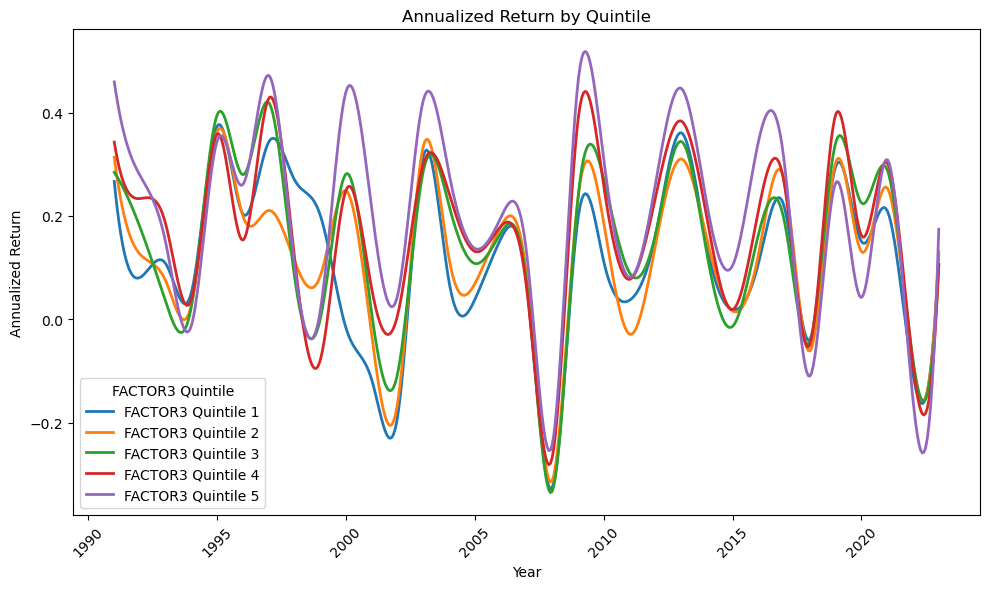

In [47]:
last_of_year = FACTOR3.groupby(['FACTOR3_QUINTILE', 'YEAR']).last().reset_index()

plt.figure(figsize=(10, 6))

for quintile in last_of_year['FACTOR3_QUINTILE'].unique():
    quintile_data = last_of_year[last_of_year['FACTOR3_QUINTILE'] == quintile]
    
    f = interpolate.interp1d(quintile_data['YEAR'], quintile_data['cumulative_ret'], kind='cubic')
    
    x_new = np.linspace(quintile_data['YEAR'].min(), quintile_data['YEAR'].max(), 500)
    y_new = f(x_new)
    
    plt.plot(x_new, y_new, label=f'FACTOR3 Quintile {quintile}', linewidth=2)

plt.title('Annualized Return by Quintile')
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.xticks(rotation=45)
plt.legend(title='FACTOR3 Quintile')
plt.tight_layout()
plt.show()

The plot above shows the annualized returns of 5 groups clearly. In the most years, the portfolio outperforms other stocks. And the statstics below show the average annualized return of the portfolio, which is 20.47%, proving the portfolio effective.

In [49]:
quintile5_perf = last_of_year[last_of_year['FACTOR3_QUINTILE'] == 5]
quintile5_ports = quintile5_perf['cumulative_ret'].describe()
quintile5_ports

count    33.000000
mean      0.204743
std       0.182624
min      -0.241890
25%       0.103867
50%       0.223004
75%       0.309023
max       0.471677
Name: cumulative_ret, dtype: float64

Set the SP500 return as the bench and compare the performances between the potfolio and SP500.

In [51]:
BENCH = df.groupby(['DATE'])['BENCH'].mean().reset_index()
BENCH

,DATE,BENCH
0,1991-02-28,0.067281
1,1991-03-31,0.022203
2,1991-04-30,0.000346
3,1991-05-31,0.038577
4,1991-06-30,-0.047893
...,...,...
390,2023-08-31,-0.017716
391,2023-09-30,-0.048719
392,2023-10-31,-0.021980
393,2023-11-30,0.089179


In [52]:
BENCH['YEAR'] = BENCH['DATE'].dt.year

def cumulative_return(group):
    return (1 + group).cumprod() - 1

BENCH['cumulative_ret'] = BENCH.groupby('YEAR')['BENCH'].transform(cumulative_return)
BENCH

,DATE,BENCH,YEAR,cumulative_ret
0,1991-02-28,0.067281,1991,0.067281
1,1991-03-31,0.022203,1991,0.090978
2,1991-04-30,0.000346,1991,0.091355
3,1991-05-31,0.038577,1991,0.133457
4,1991-06-30,-0.047893,1991,0.079172
...,...,...,...,...
390,2023-08-31,-0.017716,2023,0.174024
391,2023-09-30,-0.048719,2023,0.116827
392,2023-10-31,-0.021980,2023,0.092279
393,2023-11-30,0.089179,2023,0.189687


In [53]:
bench_perf = BENCH.groupby(['YEAR']).last().reset_index()
bench_perf = bench_perf[['YEAR','cumulative_ret']]
bench_perf.rename(columns={'cumulative_ret':'bench'},inplace=True)
bench_stats = bench_perf['bench'].describe()
bench_stats

count    33.000000
mean      0.097806
std       0.172056
min      -0.384857
25%      -0.000031
50%       0.127828
75%       0.234543
max       0.341109
Name: bench, dtype: float64

In [54]:
compare_perf = pd.merge(quintile5_perf, bench_perf, on = 'YEAR')
compare_perf 

,FACTOR3_QUINTILE,YEAR,DATE,RET,cumulative_ret,bench
0,5,1991,1991-12-31,0.086306,0.459266,0.212716
1,5,1992,1992-12-31,0.048013,0.278120,0.044643
2,5,1993,1993-12-31,0.027598,0.147678,0.070550
3,5,1994,1994-12-31,0.014553,-0.011013,-0.015393
4,5,1995,1995-12-31,0.023130,0.346113,0.341109
5,5,1996,1996-12-31,0.016283,0.261254,0.202637
6,5,1997,1997-12-31,0.023466,0.471677,0.310084
7,5,1998,1998-12-31,0.057665,0.103867,0.266685
8,5,1999,1999-12-31,0.024007,0.017592,0.195259
9,5,2000,2000-12-31,0.071233,0.441390,-0.101392


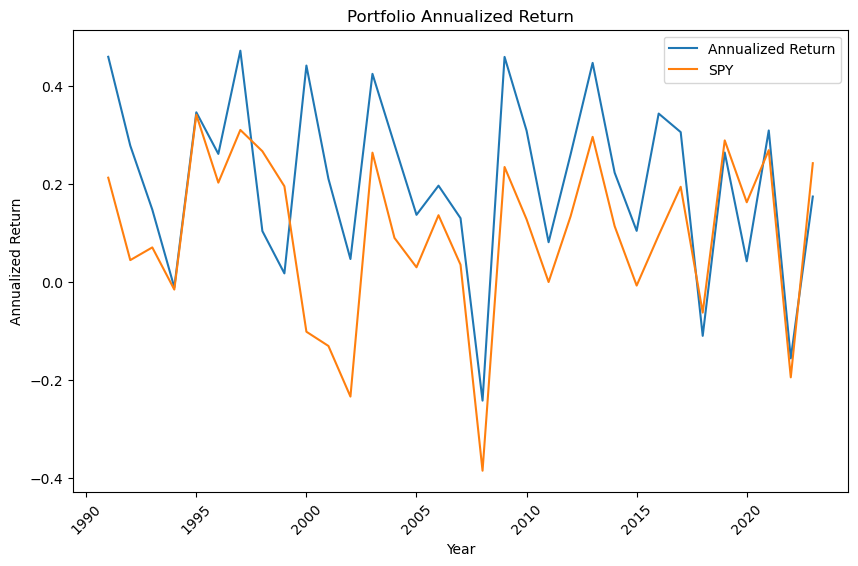

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(compare_perf['YEAR'], compare_perf['cumulative_ret'], label='Annualized Return')
plt.plot(compare_perf['YEAR'], compare_perf['bench'], label='SPY')
plt.title('Portfolio Annualized Return')
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Repete the practice to visualize the excess return and get the statistical result.

In [57]:
FACTOR3 = df.groupby(['FACTOR3_QUINTILE','DATE'])['EXRET'].mean().reset_index()
FACTOR3

,FACTOR3_QUINTILE,DATE,EXRET
0,1,1991-02-28,0.013513
1,1,1991-03-31,0.002901
2,1,1991-04-30,0.007335
3,1,1991-05-31,-0.000158
4,1,1991-06-30,-0.009676
...,...,...,...
1970,5,2023-08-31,-0.016706
1971,5,2023-09-30,0.003434
1972,5,2023-10-31,-0.010392
1973,5,2023-11-30,0.005638


In [58]:
FACTOR3['YEAR'] = FACTOR3['DATE'].dt.year

def cumulative_return(group):
    return (1 + group).cumprod() - 1

FACTOR3['cumulative_ret'] = FACTOR3.groupby(['FACTOR3_QUINTILE','YEAR'])['EXRET'].transform(cumulative_return)
FACTOR3

,FACTOR3_QUINTILE,DATE,EXRET,YEAR,cumulative_ret
0,1,1991-02-28,0.013513,1991,0.013513
1,1,1991-03-31,0.002901,1991,0.016453
2,1,1991-04-30,0.007335,1991,0.023909
3,1,1991-05-31,-0.000158,1991,0.023747
4,1,1991-06-30,-0.009676,1991,0.013842
...,...,...,...,...,...
1970,5,2023-08-31,-0.016706,2023,-0.138225
1971,5,2023-09-30,0.003434,2023,-0.135265
1972,5,2023-10-31,-0.010392,2023,-0.144251
1973,5,2023-11-30,0.005638,2023,-0.139427


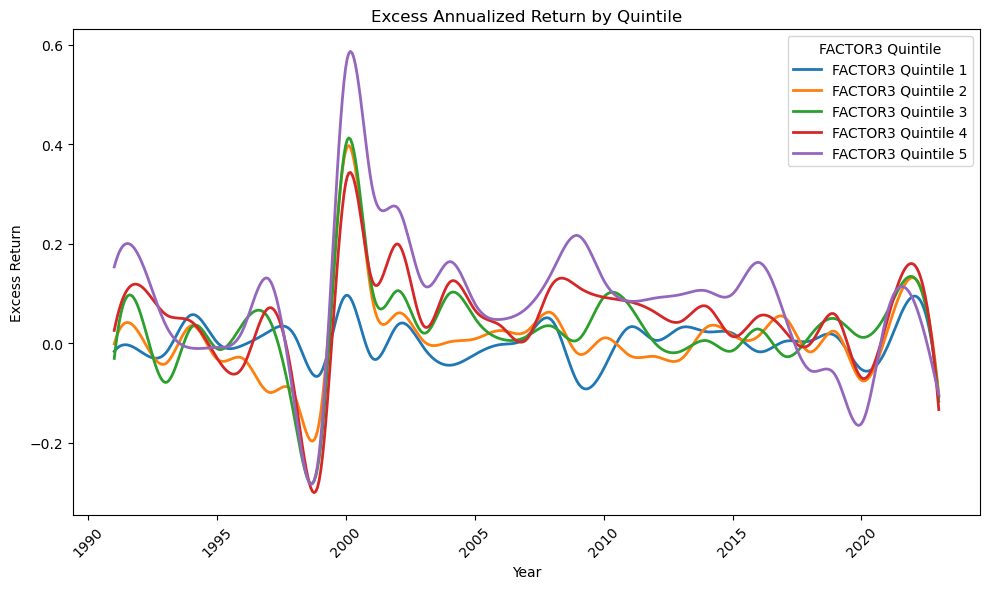

In [59]:
last_of_year = FACTOR3.groupby(['FACTOR3_QUINTILE', 'YEAR']).last().reset_index()

plt.figure(figsize=(10, 6))

for quintile in last_of_year['FACTOR3_QUINTILE'].unique():
    quintile_data = last_of_year[last_of_year['FACTOR3_QUINTILE'] == quintile]
    
    f = interpolate.interp1d(quintile_data['YEAR'], quintile_data['cumulative_ret'], kind='cubic')
    
    x_new = np.linspace(quintile_data['YEAR'].min(), quintile_data['YEAR'].max(), 500)
    y_new = f(x_new)
    
    plt.plot(x_new, y_new, label=f'FACTOR3 Quintile {quintile}', linewidth=2)

plt.title('Excess Annualized Return by Quintile')
plt.xlabel('Year')
plt.ylabel('Excess Return')
plt.xticks(rotation=45)
plt.legend(title='FACTOR3 Quintile')
plt.tight_layout()
plt.show()

In [60]:
quintile5_perf = last_of_year[last_of_year['FACTOR3_QUINTILE'] == 5]
quintile5_ports = quintile5_perf['cumulative_ret'].describe()
quintile5_ports['sharpe'] = quintile5_ports['mean'] / quintile5_ports['std']
quintile5_ports

count     33.000000
mean       0.083335
std        0.143072
min       -0.198553
25%        0.027366
50%        0.088391
75%        0.144411
max        0.560586
sharpe     0.582469
Name: cumulative_ret, dtype: float64

The average excess annualized return over the market is 8.33% for the basic portfolio and the sharpe ratio is 0.58.

## 4. Advanced Portfolio Construction

To optimize the portfolio, screen the stocks according to the finanial ratio, which is accrual, and then do the same thing as the basic portfolio.

In [64]:
def select_top_50_percent_quantile(group):
    median_value = group['accrual'].quantile(0.5)
    return group[group['accrual'] <= median_value]

df_new = df.groupby('DATE', group_keys=False).apply(select_top_50_percent_quantile).reset_index()
df_new

,index,PERMNO,DATE,BENCH,LIQUIDITY,SIZE,MOMENTUM,NLSIZE,BTOP,EARNING,...,RET,EXRET,BETA,VOLATILITY,roe,roce,accrual,divyield,score3,FACTOR3_QUINTILE
0,0,10057,1991-02-28,0.067281,0.604880,-2.633244,-2.640897,4.077355,2.912173,1.562197,...,0.232558,0.149594,0.097750,-0.271238,0.039,0.104,-0.080,0.0604,0.118087,3
1,772,10145,1991-02-28,0.067281,-0.567630,0.354625,-0.635586,-0.642713,0.976456,0.835867,...,0.041379,-0.040213,0.038037,0.410220,0.113,0.122,-0.052,0.0605,1.123954,5
2,1147,10401,1991-02-28,0.067281,-0.619401,1.756857,-0.715633,1.169513,-0.461506,-0.166442,...,0.022989,-0.023131,-1.504183,-0.527046,0.164,0.192,-0.067,0.0396,-3.092813,1
3,1282,10460,1991-02-28,0.067281,-0.704523,-1.039846,-0.788998,0.255598,-0.169891,-0.034850,...,0.156627,0.065943,0.433518,0.147400,0.163,0.157,-0.084,0.0533,0.749398,4
4,4516,11703,1991-02-28,0.067281,-0.779423,1.541299,-0.160644,0.697963,0.400768,0.327470,...,0.049517,-0.022339,-0.385268,0.118642,0.122,0.184,-0.078,0.0447,-1.911793,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52639,102950,91668,2023-12-31,0.044229,-1.096258,-1.679469,0.350066,-1.298775,-0.081266,-0.794118,...,0.133459,0.057976,1.121237,-0.173835,0.035,0.106,-0.053,0.0000,2.184127,5
52640,103011,91849,2023-12-31,0.044229,-0.946719,-0.312899,1.228246,-0.552821,-0.808031,-0.542987,...,0.065679,0.018703,-0.353907,-0.248466,0.281,0.162,-0.036,0.0156,0.322733,3
52641,103102,91937,2023-12-31,0.044229,-1.656428,1.558100,0.112055,2.015966,0.233259,-0.198952,...,0.065670,0.026901,-0.778509,-0.525193,0.098,0.085,-0.049,0.0162,-3.773019,1
52642,103227,92402,2023-12-31,0.044229,-1.216071,0.284622,0.244893,0.065012,-1.131716,-0.693727,...,0.086013,0.023913,0.428771,-1.078058,1.321,0.366,-0.041,0.0098,-1.043360,2


In [65]:
df_new['score3'] = df_new['EARNING'] - df_new['SIZE'] - df_new['NLSIZE'] 

In [66]:
df_new['FACTOR3_QUINTILE'] = df_new.groupby('DATE')['score3'].transform(lambda x: quintiles(x))
FACTOR3 = df_new.groupby(['FACTOR3_QUINTILE','DATE'])['RET'].mean()
FACTOR3 = FACTOR3.reset_index()  

In [67]:
FACTOR3['YEAR'] = FACTOR3['DATE'].dt.year

def cumulative_return(group):
    return (1 + group).cumprod() - 1

FACTOR3['cumulative_ret'] = FACTOR3.groupby(['FACTOR3_QUINTILE','YEAR'])['RET'].transform(cumulative_return)
FACTOR3

,FACTOR3_QUINTILE,DATE,RET,YEAR,cumulative_ret
0,1,1991-02-28,0.089992,1991,0.089992
1,1,1991-03-31,0.047449,1991,0.141711
2,1,1991-04-30,0.018231,1991,0.162525
3,1,1991-05-31,0.034083,1991,0.202147
4,1,1991-06-30,-0.059278,1991,0.130886
...,...,...,...,...,...
1970,5,2023-08-31,-0.021536,2023,0.105479
1971,5,2023-09-30,-0.051646,2023,0.048385
1972,5,2023-10-31,-0.030497,2023,0.016412
1973,5,2023-11-30,0.111053,2023,0.129288


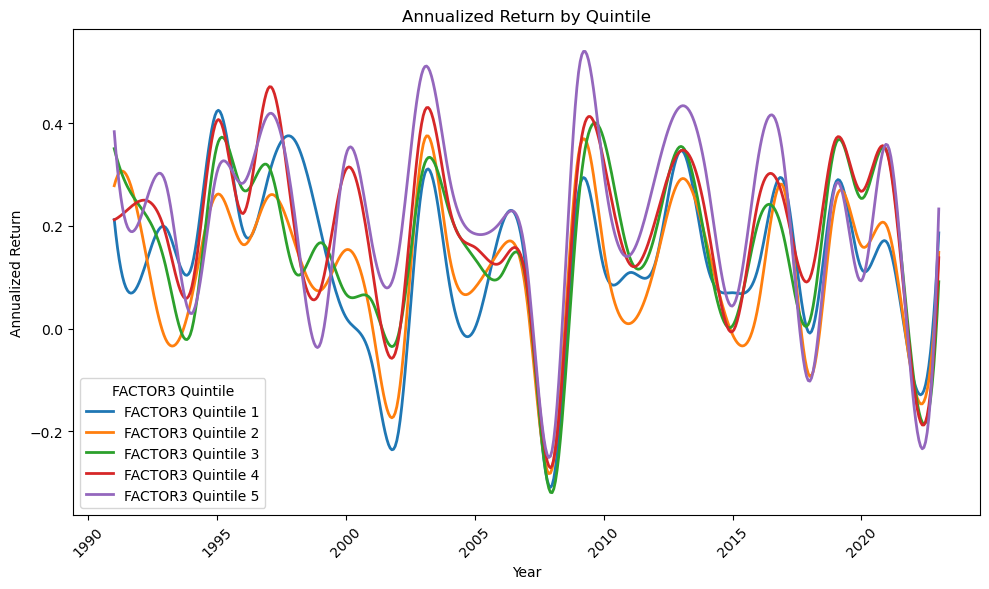

In [68]:
last_of_year = FACTOR3.groupby(['FACTOR3_QUINTILE', 'YEAR']).last().reset_index()

plt.figure(figsize=(10, 6))

for quintile in last_of_year['FACTOR3_QUINTILE'].unique():
    quintile_data = last_of_year[last_of_year['FACTOR3_QUINTILE'] == quintile]
    
    f = interpolate.interp1d(quintile_data['YEAR'], quintile_data['cumulative_ret'], kind='cubic')
    
    x_new = np.linspace(quintile_data['YEAR'].min(), quintile_data['YEAR'].max(), 500)
    y_new = f(x_new)
    
    plt.plot(x_new, y_new, label=f'FACTOR3 Quintile {quintile}', linewidth=2)

plt.title('Annualized Return by Quintile')
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.xticks(rotation=45)
plt.legend(title='FACTOR3 Quintile')
plt.tight_layout()
plt.show()

In [69]:
quintile5_perf = last_of_year[last_of_year['FACTOR3_QUINTILE'] == 5]
quintile5_ports = quintile5_perf['cumulative_ret'].describe()
quintile5_ports

count    33.000000
mean      0.218987
std       0.174440
min      -0.235785
25%       0.136714
50%       0.280153
75%       0.318678
max       0.505974
Name: cumulative_ret, dtype: float64

In [70]:
compare_perf = pd.merge(quintile5_perf, bench_perf, on = 'YEAR')

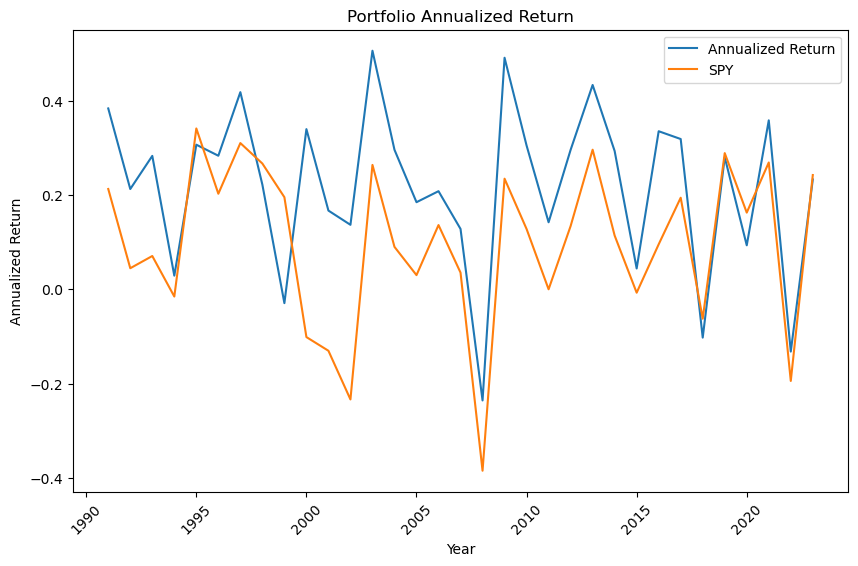

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(compare_perf['YEAR'], compare_perf['cumulative_ret'], label='Annualized Return')
plt.plot(compare_perf['YEAR'], compare_perf['bench'], label='SPY')
plt.title('Portfolio Annualized Return')
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [72]:
df_new['FACTOR2_QUINTILE'] = df_new.groupby('DATE')['score3'].transform(lambda x: quintiles(x))
FACTOR3 = df_new.groupby(['FACTOR3_QUINTILE','DATE'])['EXRET'].mean()
FACTOR3 = FACTOR3.reset_index()  

In [73]:
FACTOR3['YEAR'] = FACTOR3['DATE'].dt.year

def cumulative_return(group):
    return (1 + group).cumprod() - 1

FACTOR3['cumulative_ret'] = FACTOR3.groupby(['FACTOR3_QUINTILE','YEAR'])['EXRET'].transform(cumulative_return)
FACTOR3

,FACTOR3_QUINTILE,DATE,EXRET,YEAR,cumulative_ret
0,1,1991-02-28,0.019372,1991,0.019372
1,1,1991-03-31,0.016807,1991,0.036505
2,1,1991-04-30,0.015593,1991,0.052667
3,1,1991-05-31,-0.005805,1991,0.046556
4,1,1991-06-30,-0.014397,1991,0.031488
...,...,...,...,...,...
1970,5,2023-08-31,0.001462,2023,-0.091483
1971,5,2023-09-30,0.001381,2023,-0.090228
1972,5,2023-10-31,0.001215,2023,-0.089122
1973,5,2023-11-30,-0.000698,2023,-0.089758


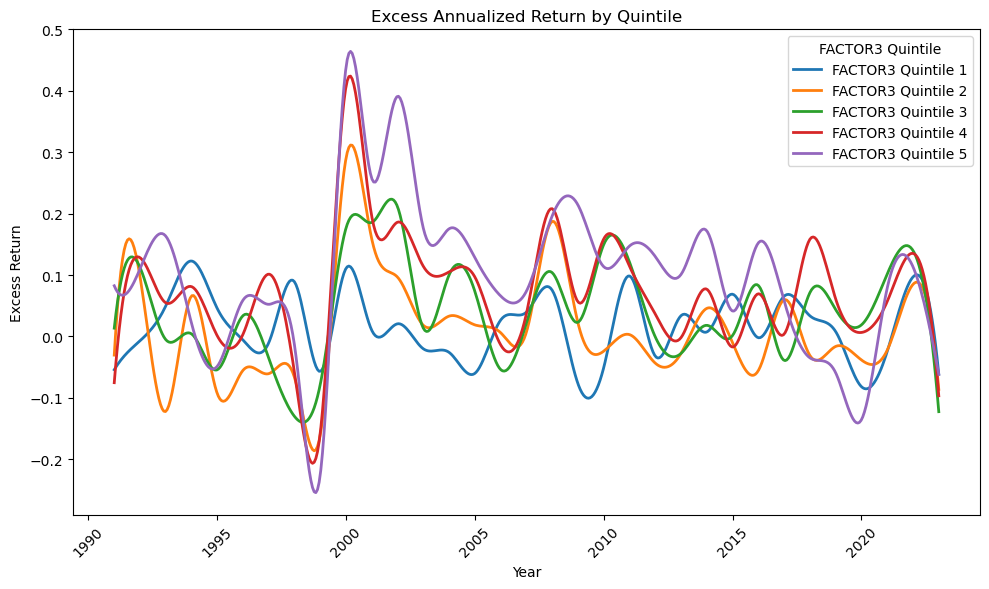

In [74]:
last_of_year = FACTOR3.groupby(['FACTOR3_QUINTILE', 'YEAR']).last().reset_index()

plt.figure(figsize=(10, 6))

for quintile in last_of_year['FACTOR3_QUINTILE'].unique():
    quintile_data = last_of_year[last_of_year['FACTOR3_QUINTILE'] == quintile]
    
    f = interpolate.interp1d(quintile_data['YEAR'], quintile_data['cumulative_ret'], kind='cubic')
    
    x_new = np.linspace(quintile_data['YEAR'].min(), quintile_data['YEAR'].max(), 500)
    y_new = f(x_new)
    
    plt.plot(x_new, y_new, label=f'FACTOR3 Quintile {quintile}', linewidth=2)

plt.title('Excess Annualized Return by Quintile')
plt.xlabel('Year')
plt.ylabel('Excess Return')
plt.xticks(rotation=45)
plt.legend(title='FACTOR3 Quintile')
plt.tight_layout()
plt.show()

In [75]:
quintile5_perf = last_of_year[last_of_year['FACTOR3_QUINTILE'] == 5]
quintile5_ports = quintile5_perf['cumulative_ret'].describe()
quintile5_ports['sharpe'] = quintile5_ports['mean'] / quintile5_ports['std']
quintile5_ports

count     33.000000
mean       0.094912
std        0.131964
min       -0.223560
25%        0.041239
50%        0.101111
75%        0.163306
max        0.439857
sharpe     0.719221
Name: cumulative_ret, dtype: float64

Overall, the advanced portfolio is much better, generating annualized return 21.90%, excess annualized return 9.49% and sharpe ratio 0.72. 